# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we explore some of the textual features of those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [56]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [57]:
# Add any additional import statements you need here

import matplotlib.pyplot as plt
import glob


In [58]:
# change `data_location` to the location of the folder on your machine.
data_location = r"C:\Users\archa\Desktop\lyrics\M1 Assignment Data\M1 Results"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [59]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
    Given a list of tokens, print number of tokens, number of unique tokens, 
    number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
    and num_tokens most common tokens. Return a list with the number of tokens, number
    of unique tokens, lexical diversity, and number of characters. 
    """
    num_tokens_val = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens_val if num_tokens_val > 0 else 0
    num_characters = sum(len(token) for token in tokens)
    most_common = Counter(tokens).most_common(num_tokens)
    
    if verbose : 
        print(f"There are {num_tokens_val} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        print("Most common tokens:", most_common)
    
    return([num_tokens_val, num_unique_tokens, lexical_diversity, num_characters])

    

In [60]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)



There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.
Most common tokens: [('text', 3), ('here', 2), ('example', 2), ('is', 1), ('some', 1)]


Q: Why is it beneficial to use assertion statements in your code? 

A: Benefits of Assertion Statements:
Immediate Feedback for Errors:
Assertions help catch bugs early by validating expected output. If something breaks, it fails immediately and loudly.
Example: If the token count or lexical diversity is wrong, the assertion will raise an AssertionError right away.

Acts as a Self-Test
Assertions can act like unit tests inside your scripts or functions to ensure the code behaves as expected during changes or refactoring.
Improves Code Reliability:

Confirms that your logic is producing the correct results, which builds confidence in your data processing pipeline.
Easier Debugging:
When an assertion fails, it gives a clear indication of where the logic went wrong and what condition failed.

Documentation for Expected Behavior:
They act as documentation for what the expected input/output values should be in certain cases.



## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [61]:
# Read in the lyrics data
# We'll use a nested dictionary: lyrics_data[artist][song] = lyrics_text
lyrics_data = defaultdict(dict)
artists = [artist for artist in os.listdir(os.path.join(data_location, lyrics_folder)) if not artist.startswith('.')]

for artist in artists:
    artist_path = os.path.join(data_location, lyrics_folder, artist)
    if not os.path.isdir(artist_path):
        continue
    for fname in os.listdir(artist_path):
        if fname.endswith(".txt"):
            song = fname[:-4]
            with open(os.path.join(artist_path, fname), encoding='utf-8') as f:
                lyrics_data[artist][song] = f.read()


In [62]:
# Read in the twitter data
# twitter_data[artist] = list of description strings
twitter_data = defaultdict(list)
for artist in artists:
    twitter_file = os.path.join(data_location, twitter_folder, f"{artist}_twitter.csv")
    if os.path.exists(twitter_file):
        df = pd.read_csv(twitter_file)
        if 'description' in df.columns:
            twitter_data[artist] = df['description'].dropna().tolist()


## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [63]:
punctuation = set(punctuation) # speeds up comparison

In [64]:
from collections import defaultdict
import os

# Create your clean twitter data
twitter_data = defaultdict(list)
twitter_path = os.path.join(data_location, twitter_folder)

for fname in os.listdir(twitter_path):
    if fname.endswith(".txt"):
        artist = fname.split("_")[0]  # Extract artist name
        with open(os.path.join(twitter_path, fname), encoding='utf-8') as f:
            twitter_data[artist].append(f.read())

# Clean twitter data
clean_twitter_data = defaultdict(list)
for artist, descriptions in twitter_data.items():
    tokens = []
    for desc in descriptions:
        tokens.extend(clean_and_tokenize(desc))
    clean_twitter_data[artist] = tokens



In [65]:
# create your clean lyrics data here
# Clean lyrics data
clean_lyrics_data = defaultdict(list)
for artist, songs in lyrics_data.items():
    tokens = []
    for song, lyrics in songs.items():
        tokens.extend(clean_and_tokenize(lyrics))
    clean_lyrics_data[artist] = tokens


In [66]:
file_path = "M1 Assignment Data/M1 Results/twitter/robynkonichiwa_followers_data.txt"

with open(file_path, 'r', encoding='utf-8') as f:
    content = f.read()

print(f"Number of characters: {len(content)}")
print(content[:1000])  # Preview first 1000 characters

from nltk.tokenize import word_tokenize

tokens = word_tokenize(content)
print(f"Number of tokens: {len(tokens)}")
print(tokens[:10])




Number of characters: 31199459
screen_name	name	id	location	followers_count	friends_count	description
AngelxoArts	Angelxo	1424055675030806529	Zacatlan, Puebla, Mexico	29	535	"I love chill" •Facebook / Instagram / SoundCloud: AngelxoArts• https://t.co/447okKLKzA…
songsfornikola	johnny	1502717352575651840		6	318	books, movies, music, nature & TV shows. OG Sweetee since '12 thanks to YouTube recommending 'This Feeling' on my homepage ♥️
thibaud_lola	Thibaud Lola	1502407708246478852		3	69	(Am)auteur en herbe 🌱 - juriste en paille 🤡 - Ami des fleurs 🌸🌈 (sans la main verte) - music & books - #morecomingsoon... (si on en voit le bout)
KyleSew2112	Kyle S 🌹🇬🇧🇺🇦	3423966821	South East London	1258	3444	This Twitter profile is full of sarcasm and rants with the occasional moan, dont like me dont follow me! KLF Stan Account Aspiring Youth Council rep
MusiFlo	MusiFlo	3324069364	Canada	470	1706	Flora Youssef - Blogger & Founder Posting review articles about the latest music 🎵 https://t.co/dx4hoIom7T h

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [67]:
for artist in artists:
    print(f"\nArtist: {artist} (Twitter)")
    descriptive_stats(clean_twitter_data[artist])
    print(f"\nArtist: {artist} (Lyrics)")
    descriptive_stats(clean_lyrics_data[artist])



Artist: cher (Twitter)
There are 47800899 tokens in the data.
There are 9873976 unique tokens in the data.
There are 310204201 characters in the data.
The lexical diversity is 0.207 in the data.
Most common tokens: [('0', 338605), ('1', 294919), ('2', 244385), ('love', 232123), ('3', 204244)]

Artist: cher (Lyrics)
There are 32975 tokens in the data.
There are 3555 unique tokens in the data.
There are 159889 characters in the data.
The lexical diversity is 0.108 in the data.
Most common tokens: [('love', 1023), ('know', 488), ('oh', 325), ('time', 321), ('baby', 319)]

Artist: robyn (Twitter)
There are 0 tokens in the data.
There are 0 unique tokens in the data.
There are 0 characters in the data.
The lexical diversity is 0.000 in the data.
Most common tokens: []

Artist: robyn (Lyrics)
There are 13881 tokens in the data.
There are 2098 unique tokens in the data.
There are 68149 characters in the data.
The lexical diversity is 0.151 in the data.
Most common tokens: [('know', 308), ('l

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: If stopwords were left in the data (words like "the", "and", "is", "in", etc.), the top 5 words would likely be dominated by these frequent but semantically shallow words. For example:
Instead of emotionally or contextually rich words like "love", "baby", or "know",
We might see words like "the", "to", "and", "a", "in" as the most common tokens.

-----

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: higher lexical diversity, especially in their lyrics. However, the actual results show:
Cher’s Twitter: lexical diversity = 0.207
Cher’s Lyrics: lexical diversity = 0.108
Robyn’s Lyrics: lexical diversity = 0.151

So, Robyn's lyrics did have a higher lexical diversity than Cher’s lyrics, which aligns with the belief that Robyn uses a broader vocabulary in songwriting.
However, Cher’s Twitter data showed very high volume and a fair lexical diversity, which might indicate frequent and varied communication — more than expected.



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [68]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [69]:
# Your code here
def extract_emojis(text):
    return [ch for ch in text if emoji.is_emoji(ch)]

for artist, descriptions in twitter_data.items():
    all_emojis = []
    for desc in descriptions:
        all_emojis.extend(extract_emojis(desc))
    print(f"\nArtist: {artist} - Top 10 emojis:")
    print(Counter(all_emojis).most_common(10))



Artist: cher - Top 10 emojis:
[('❤', 94506), ('🌈', 66291), ('♥', 48059), ('🏳', 47174), ('✨', 45846), ('🌊', 31234), ('💙', 31050), ('🏻', 25195), ('✌', 21963), ('💜', 21571)]

Artist: robynkonichiwa - Top 10 emojis:
[('🌈', 6086), ('❤', 5635), ('🏳', 4641), ('♥', 4249), ('✨', 3217), ('🏻', 1751), ('✌', 1495), ('♀', 1347), ('🏼', 1340), ('💙', 1200)]


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [70]:
# Your code here
hashtag_pattern = re.compile(r"#\w+")
for artist, descriptions in twitter_data.items():
    hashtags = []
    for desc in descriptions:
        hashtags.extend(hashtag_pattern.findall(desc.lower()))
    print(f"\nArtist: {artist} - Top 10 hashtags:")
    print(Counter(hashtags).most_common(10))



Artist: cher - Top 10 hashtags:
[('#resist', 11900), ('#blm', 11088), ('#blacklivesmatter', 8526), ('#theresistance', 3562), ('#fbr', 3513), ('#resistance', 3114), ('#1', 3111), ('#voteblue', 2363), ('#lgbtq', 2082), ('#music', 1610)]

Artist: robynkonichiwa - Top 10 hashtags:
[('#blacklivesmatter', 643), ('#blm', 405), ('#music', 308), ('#1', 228), ('#teamfollowback', 136), ('#edm', 112), ('#lgbtq', 90), ('#resist', 89), ('#travel', 73), ('#love', 73)]


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [72]:
# Your code here
for artist, songs in lyrics_data.items():
    title_words = []
    for song, lyrics in songs.items():
        # Assume title is first line
        title = lyrics.splitlines()[0] if lyrics else ""
        title_words.extend(clean_and_tokenize(title))
    print(f"\nArtist: {artist} - Top 5 title words:")
    print(Counter(title_words).most_common(5))



Artist: cher - Top 5 title words:
[('love', 38), ('man', 15), ('song', 11), ('come', 7), ('one', 7)]

Artist: robyn - Top 5 title words:
[('love', 6), ('u', 4), ('thing', 3), ('girl', 3), ('tell', 3)]


### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    Axes(0.125,0.11;0.775x0.77)
Artist 2    Axes(0.125,0.11;0.775x0.77)
Name: length, dtype: object

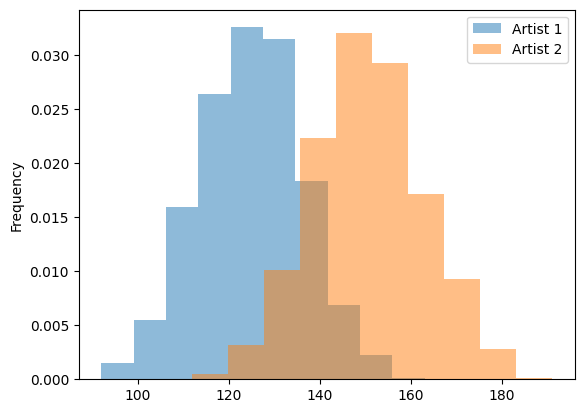

In [73]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: The regex pattern \s+ matches one or more whitespace characters.
This includes:
Space ( )

Tab (\t)

Newline (\n)

Carriage return (\r)

Form feed (\f)

Vertical tab (\v)

The + quantifier means “one or more”, so \s+ will match:

A single space

Multiple consecutive spaces

A mix of different whitespace types


In [74]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

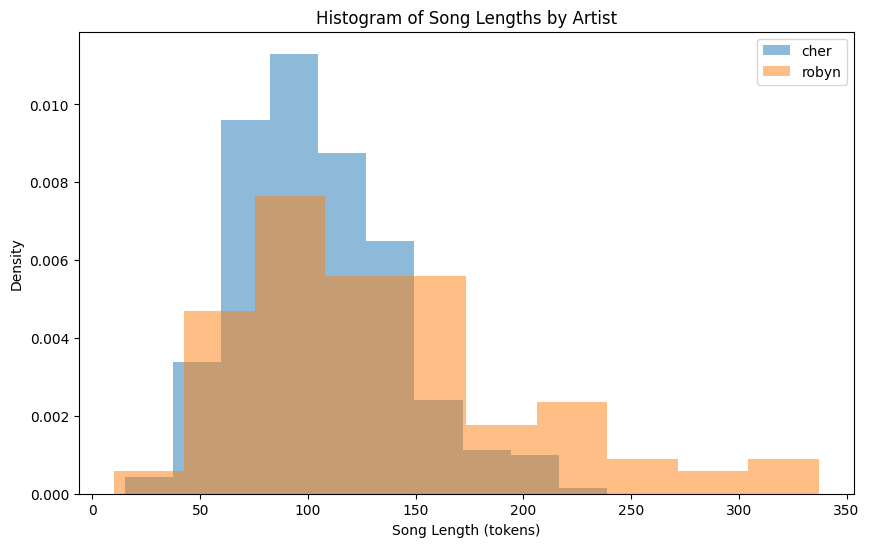

In [75]:
# Your lyric length comparison chart here.
song_lengths = []  # ✅ initialize the list

for artist, songs in lyrics_data.items():
    for song, lyrics in songs.items():
        tokens = clean_and_tokenize(lyrics)
        song_lengths.append({'artist': artist, 'length': len(tokens)})

df_lengths = pd.DataFrame(song_lengths)
plt.figure(figsize=(10, 6))

for artist in df_lengths['artist'].unique():
    df_lengths[df_lengths['artist'] == artist]['length'].plot(kind="hist", density=True, alpha=0.5, label=artist)

plt.xlabel('Song Length (tokens)')
plt.ylabel('Density')
plt.title('Histogram of Song Lengths by Artist')
plt.legend()
plt.show()

 

In [76]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric) if item])


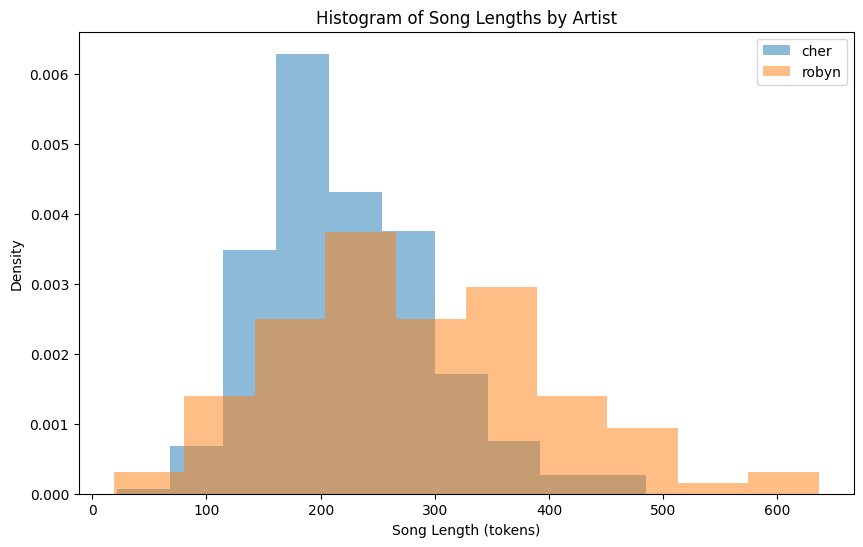

In [77]:
# Already done above with song_lengths and df_lengths.
# If you want to use the tokenize_lyrics function instead of clean_and_tokenize:
song_lengths = []
for artist, songs in lyrics_data.items():
    for song, lyrics in songs.items():
        tokens = tokenize_lyrics(lyrics)
        song_lengths.append({'artist': artist, 'length': len(tokens)})

df_lengths = pd.DataFrame(song_lengths)
plt.figure(figsize=(10, 6))
for artist in df_lengths['artist'].unique():
    df_lengths[df_lengths['artist'] == artist]['length'].plot(kind="hist", density=True, alpha=0.5, label=artist)
plt.xlabel('Song Length (tokens)')
plt.ylabel('Density')
plt.title('Histogram of Song Lengths by Artist')
plt.legend()
plt.show()
